## Part 1.3 - Data normalization
#### *Pol Roca Llaberia*

In this notebook we will start to try to improve the performance of a model when it has few data available. The first improvement that we will apply is data normalization, a technique that theoretically we should be applying always anyway.

To simulate the lack of data, we will only feed 300 instances to the model and we will compare the results both when normalizing or not the data. On the contrary the test set will remain the same, which means we will have an unrepresentative training set, but that condition will hold for all the evaluated models and this way we will obtain a more stable validation.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np 

In [16]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [17]:
N = 300

In [18]:
X_train = X_train[:N]
y_train = y_train[:N]
X_test = X_test[:2500]
y_test = y_test[:2500]

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

Normalize the dataset

In [19]:
X_train_norm = X_train.astype("float32") / X_train.max()
X_test_norm = X_test.astype("float32") / X_test.max()

In [20]:
print(X_train.shape)
print(X_test.shape)
np.unique(y_test, return_counts=True)

(300, 28, 28, 1)
(2500, 28, 28, 1)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([219, 287, 276, 254, 275, 221, 225, 257, 242, 244]))

In [21]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(20, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes))
    return model

In [22]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                28810     
Total params: 29,330
Trainable params: 29,330
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

When it is possible, we save the model weights so that each experiment starts from the same exact point with the same randomness

In [24]:
model.save_weights('initial.h5')

In [25]:
histories = []
metrics = []
epochs = 100

for X_train, y_train, X_test, y_test in [(X_train, y_train, X_test, y_test),
                                         (X_train_norm, y_train, X_test_norm, y_test)]:
    model.load_weights('initial.h5')
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=32, 
                        validation_data=(X_test, y_test), 
                        verbose=1)
    histories.append(history.history)
    metrics.append(model.evaluate(X_test,  y_test))

Epoch 1/100
10/10 [==============================] - 1s 46ms/step - loss: 660.5707 - accuracy: 0.0921 - val_loss: 2.2766 - val_accuracy: 0.1488
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 2.2155 - accuracy: 0.2115 - val_loss: 2.1992 - val_accuracy: 0.2240
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 2.2876 - accuracy: 0.1927 - val_loss: 2.2984 - val_accuracy: 0.1484
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 2.2828 - accuracy: 0.1839 - val_loss: 2.2895 - val_accuracy: 0.1476
Epoch 5/100
10/10 [==============================] - 0s 27ms/step - loss: 2.2297 - accuracy: 0.1536 - val_loss: 2.2932 - val_accuracy: 0.1356
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 2.2936 - accuracy: 0.1900 - val_loss: 2.2965 - val_accuracy: 0.1436
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 2.1401 - accuracy: 0.2720 - val_loss: 2.0530 - val_accuracy: 0.3056
Epoc

In [26]:
for loss, acc in np.round(metrics, 2):
    print(f'loss: {loss:.2f} accuracy: {acc:.2f}')

loss: 4.49 accuracy: 0.60
loss: 0.78 accuracy: 0.76


In [27]:
def plot_curves(history, axes, title=''):
    # plot accuracy
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(acc)+1)

    ax = axes[0]
    ax.plot(epochs, acc, 'b', label='Training Acc')
    ax.plot(epochs, val_acc, 'r', label='Validation Acc')
    ax.set_title('Accuracy curves | ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.grid(alpha=0.4)
    ax.legend()

    # plot validation loss
    loss = history['loss']
    val_loss = history['val_loss']

    ax = axes[1]
    ax.plot(epochs, loss, 'b', label='Training loss')
    ax.plot(epochs, val_loss, 'r', label='Validation loss')
    ax.set_title('Loss curves | ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(alpha=0.4)
    ax.legend()

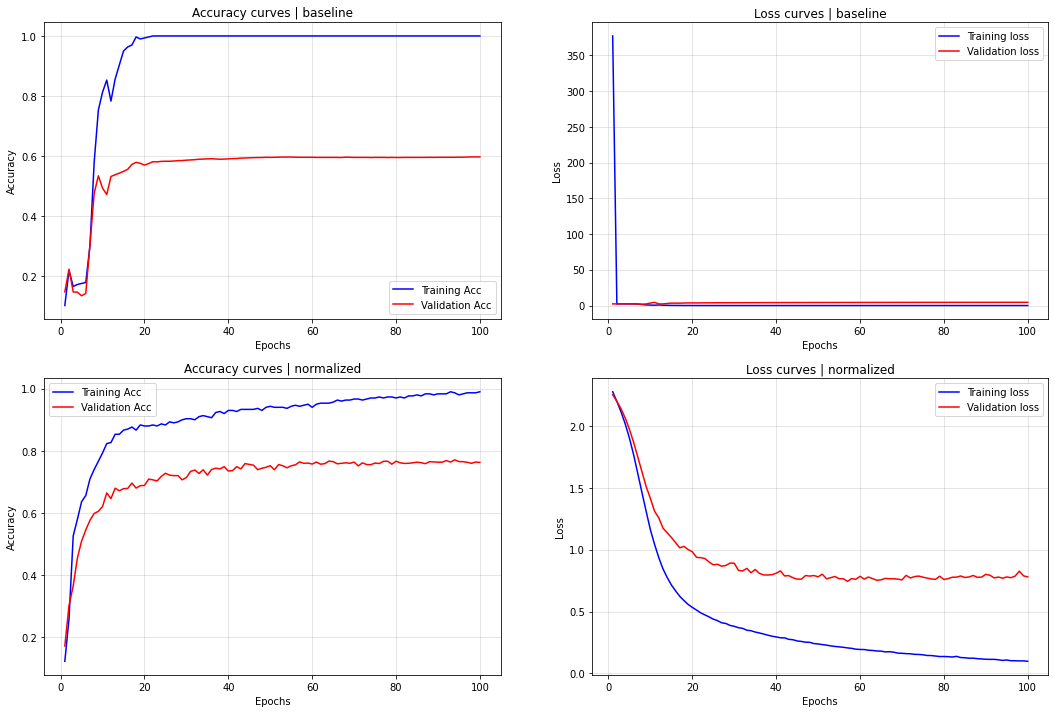

In [28]:
fig, axes = plt.subplots(len(histories), 2, figsize=(18, 6*len(histories)))

plot_curves(histories[0], axes[0], 'baseline')
plot_curves(histories[1], axes[1], 'normalized')

plt.show()

### Observations

As we can see, data normalization is a neat improvement over the baseline model. In terms of numbers, the accuracy got increased by 27% (0.6 vs 0.76), which is outstanding. 

The better results may not only be observed in the accuracy, but also in the validation loss. Normalizing the images has helped the model reach the minimum much more smoothly, and that has prevented it from overfitting. There is still a gap between loss curves, indeed, but now the model has reached that point by slowly learning the patterns, instead of memorizing them.

---